# 0. Описание задачи

Датасет содержит информацию о продажах, перемещениях товаров между магазинами и складами, а также сведения о поставщиках и типах товаров.

**Цель:**  
Построить модель машинного обучения для классификации товаров по их типу (`ITEM TYPE`), основываясь на данных о продажах, перемещениях и других признаках.

Тип задачи — **многоклассовая классификация**.

# 1. Прочитать данные

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sklearn
import hdbscan

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid", palette="Set2")

In [ ]:
from google.colab import files

uploaded = files.upload()

df = pd.read_csv('Warehouse_and_Retail_Sales.csv')

Saving Warehouse_and_Retail_Sales.csv to Warehouse_and_Retail_Sales (6).csv


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307645 entries, 0 to 307644
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   YEAR              307645 non-null  int64  
 1   MONTH             307645 non-null  int64  
 2   SUPPLIER          307478 non-null  object 
 3   ITEM CODE         307645 non-null  object 
 4   ITEM DESCRIPTION  307645 non-null  object 
 5   ITEM TYPE         307644 non-null  object 
 6   RETAIL SALES      307642 non-null  float64
 7   RETAIL TRANSFERS  307645 non-null  float64
 8   WAREHOUSE SALES   307645 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 21.1+ MB
None


## Описание признаков датасета *Warehouse_and_Retail_Sales.csv*

**1. `ITEM TYPE` — Тип товара.**  
Категориальный признак, обозначающий вид продукции (например, напитки, бакалея, электроника и т.д.).  
Используется как **целевая переменная** при решении задачи классификации. Анализ по этому признаку позволяет понять, какие товары продаются лучше, а также построить модель, предсказывающую тип товара по другим характеристикам.

---

**2. `YEAR` — Год наблюдения.**  
Целочисленный временной признак, указывающий, за какой год собраны данные.  
Может отражать **долгосрочные тренды в продажах** (например, рост или спад спроса на определённые категории товаров). В некоторых случаях — вспомогательный признак для анализа динамики.

---

**3. `MONTH` — Месяц наблюдения.**  
Категориальный или целочисленный временной признак (1–12), указывающий месяц, когда были зафиксированы данные продаж.  
Важен для выявления **сезонных закономерностей** — например, пиков продаж перед праздниками или снижений в «низкий сезон».

---

**4. `RETAIL SALES` — Розничные продажи.**  
Непрерывный числовой признак, отражающий **объём или сумму розничных продаж** данного типа товара.  
Это один из ключевых показателей эффективности продаж в розничной сети.  
Высокие значения обычно соответствуют популярным товарам, что делает этот признак важным для прогнозирования типа товара.

---

**5. `RETAIL TRANSFERS` — Перемещения в рознице.**  
Числовой признак, показывающий количество или объём **перемещений товаров между розничными точками**.  
Может использоваться для анализа логистических процессов и распределения запасов.  
Если данный показатель слабо зависит от типа товара, его можно исключить из модели как **малоинформативный признак**.

---

**6. `WAREHOUSE SALES` — Продажи со склада.**  
Непрерывный числовой признак, показывающий **объём продаж, осуществлённых со складов**.  
Часто коррелирует с розничными продажами (`RETAIL SALES`), но может также отражать особенности **оптовых поставок** или складских запасов.  
Сильная корреляция между этими признаками требует анализа на мультиколлинеарность.

---

**7. `SUPPLIER` — Поставщик.**  
Категориальный признак, идентифицирующий **поставщика товара**.  
Может влиять на объём продаж, качество и цену продукции.  
В задаче классификации — полезный источник информации, если поставщики специализируются на определённых типах товаров.  

---

**8. `ITEM CODE` — Код товара.**  
Категориальный, но фактически **идентификаторный** признак, уникально определяющий конкретный товар.  
Он не отражает реальных свойств или характеристик товара — это **вспомогательный идентификатор**, часто дублирующий `ITEM DESCRIPTION`.  

---

**9. `ITEM DESCRIPTION` — Описание товара.**  
Текстовый признак, содержащий **словесное описание** товара (например, "Organic Apple Juice 1L").  
Может быть потенциально информативным, так как в нём заложены **семантические признаки** — категория, упаковка, тип продукта и т.д.  

---

## Целевая переменная
**`ITEM TYPE`** — именно этот признак используется как **целевой класс** для задачи классификации.  
Модель обучается по остальным признакам, чтобы по значениям продаж, поставщиков и характеристикам периода **предсказать тип товара**.

---

## Общие замечания
- `RETAIL SALES` и `WAREHOUSE SALES` обычно являются **основными информативными признаками**, отражающими поведение спроса.  
- `RETAIL TRANSFERS` может иметь **низкое влияние**, если значения близки по всем типам товаров.  
- `YEAR` и `MONTH` помогают выявлять **сезонность**, но при коротком временном диапазоне (1–2 года) их значимость может быть низкой.  
- `SUPPLIER` даёт **качественную сегментацию** по источникам продукции и может усиливать модель.  
- Если обнаружены сильные корреляции между признаками (например, между `RETAIL SALES` и `WAREHOUSE SALES`), стоит оставить только один из них.


# 2. Визуализировать данные и вычислить основные характеристики

(307645, 9)
Index(['YEAR', 'MONTH', 'SUPPLIER', 'ITEM CODE', 'ITEM DESCRIPTION',
       'ITEM TYPE', 'RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES'],
      dtype='object')
   YEAR  MONTH                           SUPPLIER ITEM CODE  \
0  2020      1  REPUBLIC NATIONAL DISTRIBUTING CO    100009   
1  2020      1                          PWSWN INC    100024   
2  2020      1            RELIABLE CHURCHILL LLLP      1001   
3  2020      1          LANTERNA DISTRIBUTORS INC    100145   
4  2020      1               DIONYSOS IMPORTS INC    100293   

                      ITEM DESCRIPTION ITEM TYPE  RETAIL SALES  \
0                  BOOTLEG RED - 750ML      WINE          0.00   
1            MOMENT DE PLAISIR - 750ML      WINE          0.00   
2  S SMITH ORGANIC PEAR CIDER - 18.7OZ      BEER          0.00   
3        SCHLINK HAUS KABINETT - 750ML      WINE          0.00   
4       SANTORINI GAVALA WHITE - 750ML      WINE          0.82   

   RETAIL TRANSFERS  WAREHOUSE SALES  
0     

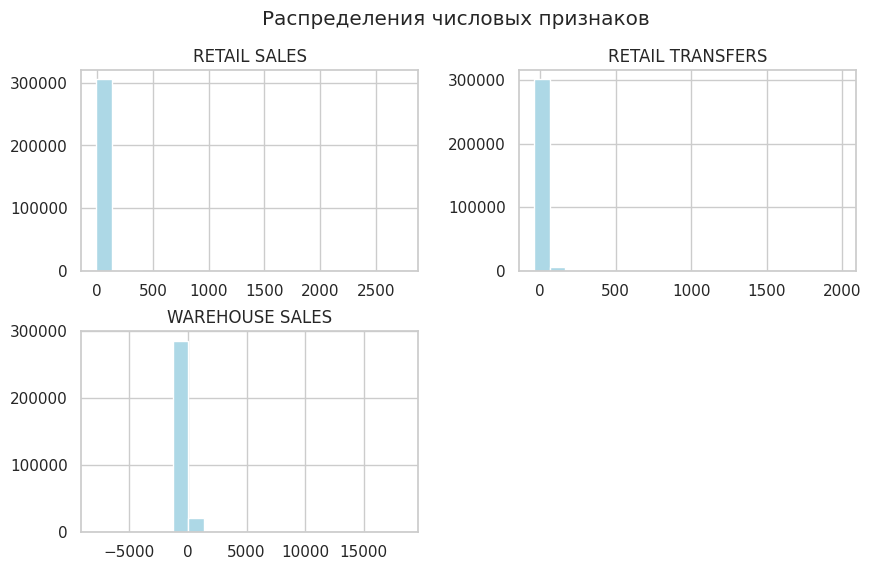

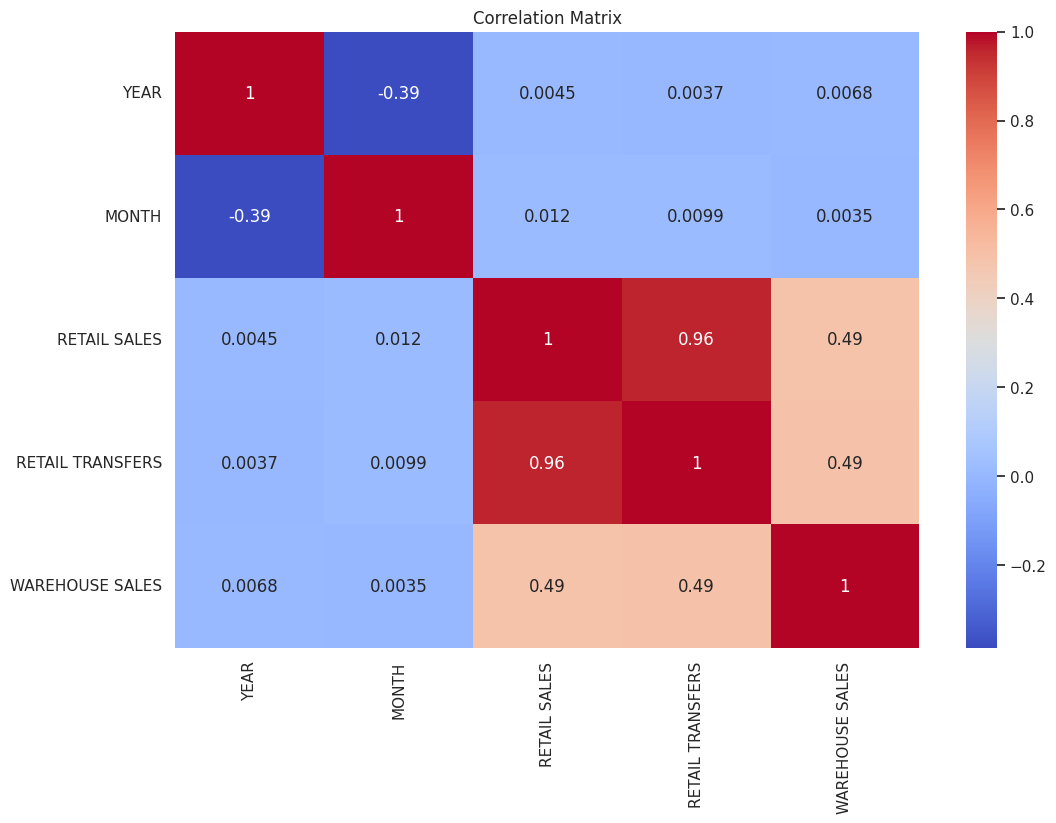

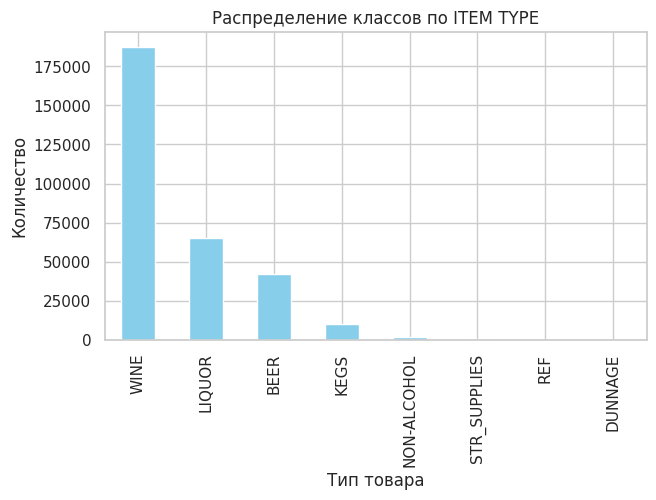

In [ ]:
print(df.shape)
print(df.columns)
print(df.head())

# Описательные статистики числовых признаков
print(df.describe())

# Основные категориальные признаки
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(exclude='object').columns

print("Категориальные признаки:", list(cat_cols))
print("Числовые признаки:", list(num_cols))

# Количество уникальных значений
for col in df.columns:
    unique_vals = df[col].nunique()
    if unique_vals < 20:
        print(f"{col}: {unique_vals} уникальных значений → категориальный признак")
    else:
        print(f"{col}: {unique_vals} уникальных значений → числовой/континуальный признак")

# Распределения числовых признаков
num_cols = ['RETAIL SALES', 'RETAIL TRANSFERS', 'WAREHOUSE SALES']
df[num_cols].hist(bins=20, figsize=(10, 6), color='lightblue')
plt.suptitle("Распределения числовых признаков")
plt.show()

# Корреляционная матрица для числовых признаков
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Распределение целевого признака
plt.figure(figsize=(7,4))
df['ITEM TYPE'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Распределение классов по ITEM TYPE")
plt.xlabel("Тип товара")
plt.ylabel("Количество")
plt.show()

Признаки `ITEM DESCRIPTION` и `ITEM CODE` удаляются, так как не несут смысловой информации для обучения. Признаки  `RETAIL SALES` и `RETAIL TRANSFERS` сильно коррелируют, поэтому удалим `RETAIL TRANSFERS`.Это избавляет от мультиколлинеарности, которая ухудшает обобщающую способность модели.

In [ ]:
df = df.drop(columns=['ITEM CODE', 'ITEM DESCRIPTION', 'RETAIL TRANSFERS'])
print("Оставшиеся признаки:", df.columns)

Оставшиеся признаки: Index(['YEAR', 'MONTH', 'SUPPLIER', 'ITEM TYPE', 'RETAIL SALES',
       'WAREHOUSE SALES'],
      dtype='object')


Поскольку корреляция слабая, можно рассмотреть вариант исключения vehicle_year из данных, если это поможет упростить модель. Однако, если в задаче важны даже слабые связи, этот признак можно оставить.

                YEAR          MONTH   RETAIL SALES  WAREHOUSE SALES
count  307645.000000  307645.000000  307642.000000    307645.000000
mean     2018.438525       6.423862       7.024071        25.294597
std         1.083061       3.461812      30.986238       249.916798
min      2017.000000       1.000000      -6.490000     -7800.000000
25%      2017.000000       3.000000       0.000000         0.000000
50%      2019.000000       7.000000       0.320000         1.000000
75%      2019.000000       9.000000       3.267500         5.000000
max      2020.000000      12.000000    2739.000000     18317.000000


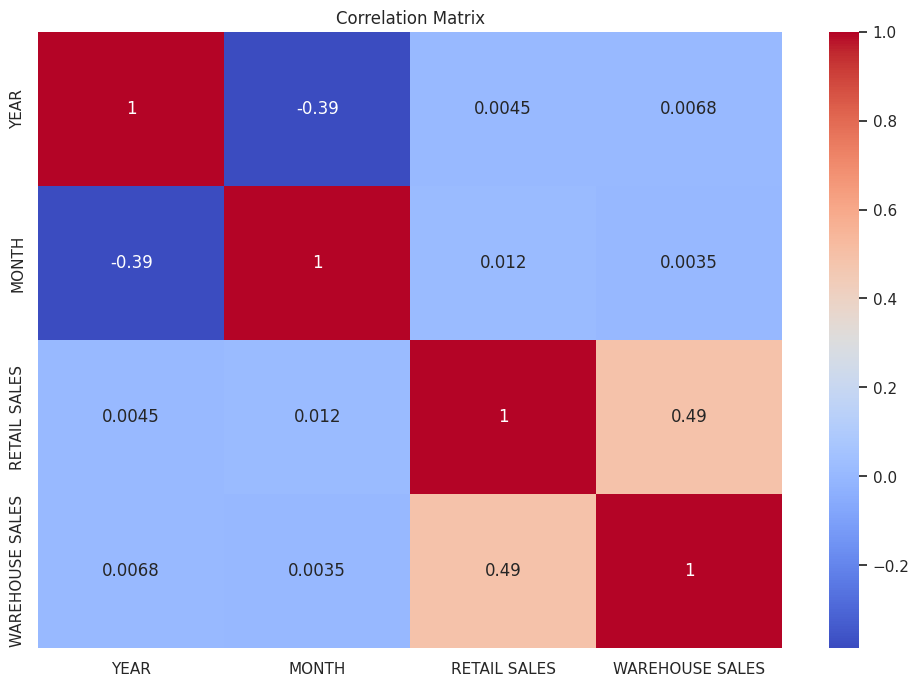

In [ ]:
# Описательные статистики числовых признаков
print(df.describe())

# Корреляционная матрица для числовых признаков
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Обработка пропущенных значений.

In [ ]:
missing_info = df.isnull().sum()
print(missing_info)

YEAR                 0
MONTH                0
SUPPLIER           167
ITEM TYPE            1
RETAIL SALES         3
WAREHOUSE SALES      0
dtype: int64


In [ ]:
# Заполнение пропусков медианными значениями для числовых признаков
df['SUPPLIER'] = df['SUPPLIER'].fillna('MISSING')
for col in ['RETAIL SALES', 'WAREHOUSE SALES']:
    df[col] = df[col].fillna(df[col].median())

df['ITEM TYPE'] = df['ITEM TYPE'].fillna(df['ITEM TYPE'].mode()[0])

# Проверка, что все пропуски устранены
print("\nПроверка на пропуски после обработки:\n", df.isnull().sum().sum())


Проверка на пропуски после обработки:
 0


# 4. Обработка категориальных признаков

In [ ]:
print(df.columns)
le = LabelEncoder()
df['SUPPLIER'] = le.fit_transform(df['SUPPLIER'])
df['ITEM TYPE'] = le.fit_transform(df['ITEM TYPE'])

df.head()

Index(['YEAR', 'MONTH', 'SUPPLIER', 'ITEM TYPE', 'RETAIL SALES',
       'WAREHOUSE SALES'],
      dtype='object')


,YEAR,MONTH,SUPPLIER,ITEM TYPE,RETAIL SALES,WAREHOUSE SALES
0,2020,1,274,7,0.00,2.0
1,2020,1,265,7,0.00,4.0
2,2020,1,272,0,0.00,1.0
3,2020,1,186,7,0.00,1.0
4,2020,1,91,7,0.82,0.0


Преобразование категориальных переменных в бинарные столбцы часто повышает точность моделей машинного обучения, так как позволяет им лучше захватывать связи между переменными.
drop_first=True, чтобы избежать мультиколлинеарности (когда сумма dummy-переменных = 1, что делает одну из них линейно зависимой от других).

In [ ]:
df = pd.get_dummies(df, columns=['YEAR', 'MONTH'], drop_first=True)
print(df.columns)
df.head()

Index(['SUPPLIER', 'ITEM TYPE', 'RETAIL SALES', 'WAREHOUSE SALES', 'YEAR_2018',
       'YEAR_2019', 'YEAR_2020', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5',
       'MONTH_6', 'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11',
       'MONTH_12'],
      dtype='object')


,SUPPLIER,ITEM TYPE,RETAIL SALES,WAREHOUSE SALES,YEAR_2018,YEAR_2019,YEAR_2020,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12
0,274,7,0.00,2.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
1,265,7,0.00,4.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,272,0,0.00,1.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
3,186,7,0.00,1.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False
4,91,7,0.82,0.0,False,False,True,False,False,False,False,False,False,False,False,False,False,False


            SUPPLIER      ITEM TYPE   RETAIL SALES  WAREHOUSE SALES
count  307645.000000  307645.000000  307645.000000    307645.000000
mean      187.292623       5.003498       7.024006        25.294597
std       108.666602       2.653213      30.986094       249.916798
min         0.000000       0.000000      -6.490000     -7800.000000
25%        90.000000       3.000000       0.000000         0.000000
50%       191.000000       7.000000       0.320000         1.000000
75%       274.000000       7.000000       3.260000         5.000000
max       396.000000       7.000000    2739.000000     18317.000000


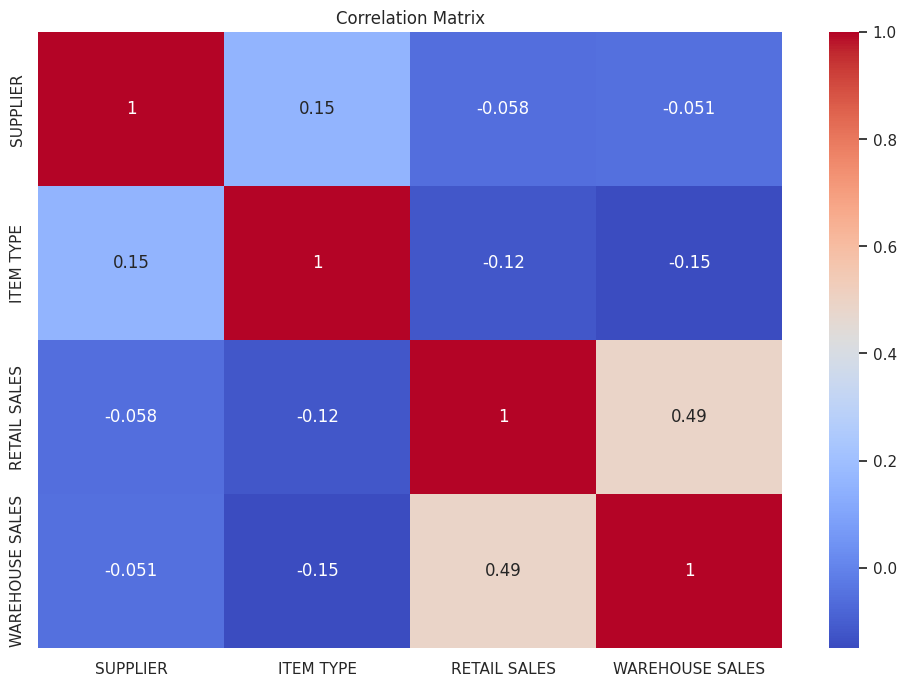

In [ ]:
# Описательные статистики числовых признаков
print(df.describe())

# Корреляционная матрица для числовых признаков
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=[float, int]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 5. Провести нормализацию

Рассматриваем какой метод нормализации применить. Также смотрим распределние признаков `RETAIL SALES` и `WIREHOUSE SALES` и их выбросы.

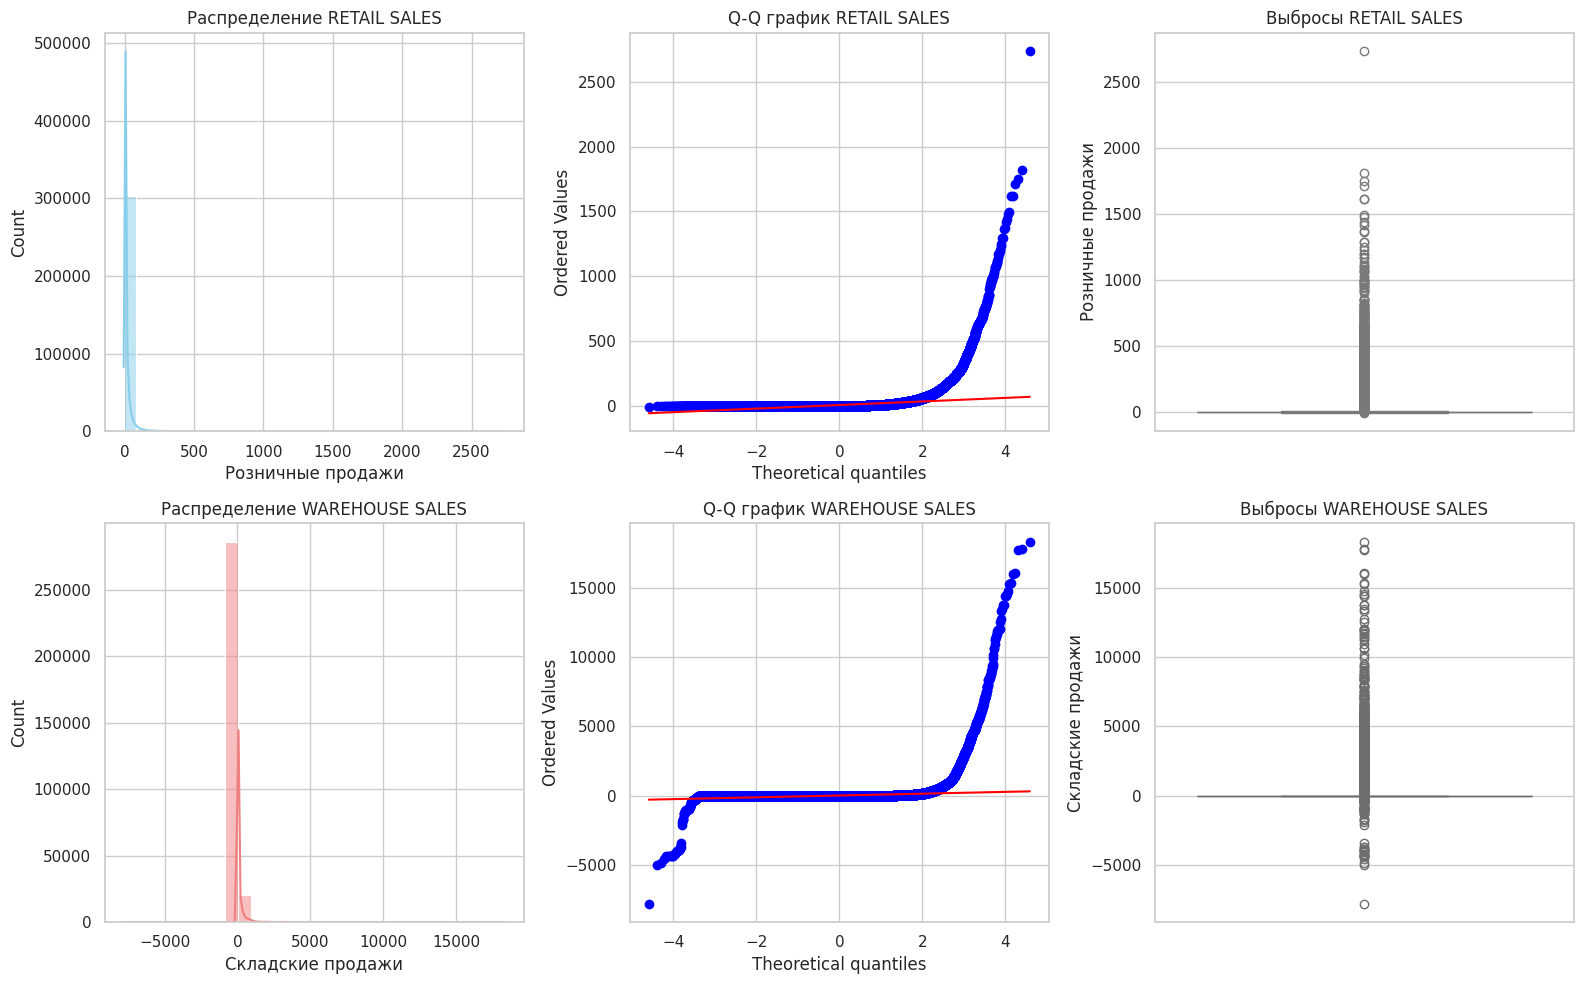

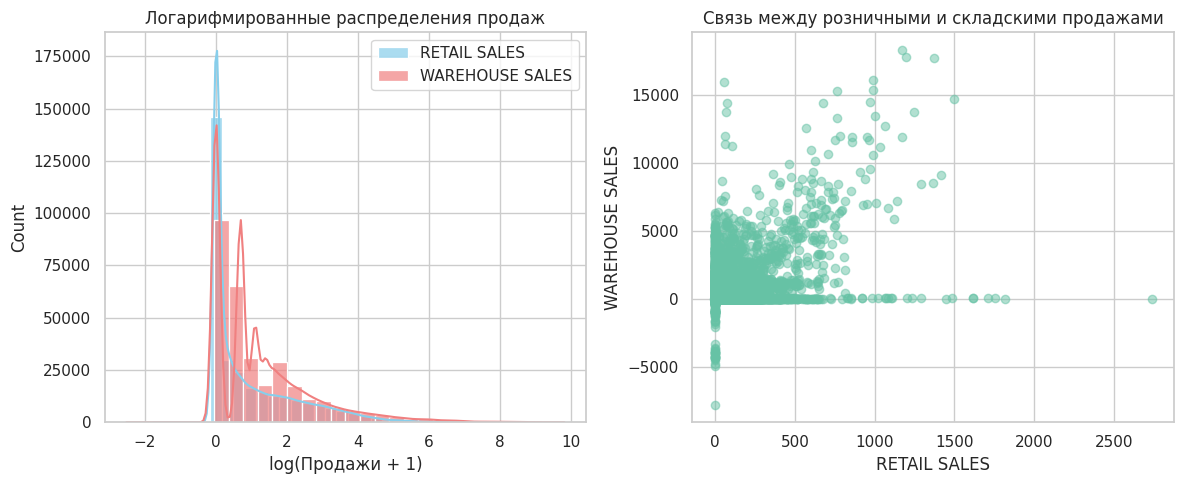

In [ ]:
plt.figure(figsize=(16, 10))

# Анализ RETAIL SALES
plt.subplot(2, 3, 1)
sns.histplot(df['RETAIL SALES'], bins=30, kde=True, color='skyblue')
plt.title('Распределение RETAIL SALES')
plt.xlabel('Розничные продажи')

plt.subplot(2, 3, 2)
stats.probplot(df['RETAIL SALES'], dist="norm", plot=plt)
plt.title('Q-Q график RETAIL SALES')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['RETAIL SALES'], color='lightblue')
plt.title('Выбросы RETAIL SALES')
plt.ylabel('Розничные продажи')

# Анализ WAREHOUSE SALES
plt.subplot(2, 3, 4)
sns.histplot(df['WAREHOUSE SALES'], bins=30, kde=True, color='lightcoral')
plt.title('Распределение WAREHOUSE SALES')
plt.xlabel('Складские продажи')

plt.subplot(2, 3, 5)
stats.probplot(df['WAREHOUSE SALES'], dist="norm", plot=plt)
plt.title('Q-Q график WAREHOUSE SALES')

plt.subplot(2, 3, 6)
sns.boxplot(y=df['WAREHOUSE SALES'], color='lightcoral')
plt.title('Выбросы WAREHOUSE SALES')
plt.ylabel('Складские продажи')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Логарифмированная версия для лучшей визуализации
retail_log = np.log1p(df['RETAIL SALES'])
warehouse_log = np.log1p(df['WAREHOUSE SALES'])

sns.histplot(retail_log, bins=30, kde=True, color='skyblue', alpha=0.7, label='RETAIL SALES')
sns.histplot(warehouse_log, bins=30, kde=True, color='lightcoral', alpha=0.7, label='WAREHOUSE SALES')
plt.title('Логарифмированные распределения продаж')
plt.xlabel('log(Продажи + 1)')
plt.legend()

plt.subplot(1, 2, 2)
# Scatter plot для визуализации связи между признаками
plt.scatter(df['RETAIL SALES'], df['WAREHOUSE SALES'], alpha=0.5)
plt.xlabel('RETAIL SALES')
plt.ylabel('WAREHOUSE SALES')
plt.title('Связь между розничными и складскими продажами')

plt.tight_layout()
plt.show()

Приступим к нормализации `RETAIL SALES` и `WIREHOUSE SALES`.
Для скошенных данных логарифм сгладит распределение и уменьшит влияние выбросов.

In [ ]:
# Чтобы избежать log(0), добавляем константу и берем абсолютное значение
df['RETAIL SALES'] = np.log1p(np.abs(df['RETAIL SALES']))
df['WAREHOUSE SALES'] = np.log1p(np.abs(df['WAREHOUSE SALES']))

Теперь можно применять StandardScaler, потому что распределения стали ближе к нормальным.

In [ ]:
scaler = StandardScaler()
df[['RETAIL SALES', 'WAREHOUSE SALES']] = scaler.fit_transform(df[['RETAIL SALES', 'WAREHOUSE SALES']])

In [ ]:
scaler = RobustScaler()
df[['RETAIL SALES', 'WAREHOUSE SALES']] = scaler.fit_transform(df[['RETAIL SALES', 'WAREHOUSE SALES']])

Проверим результат нормализации.

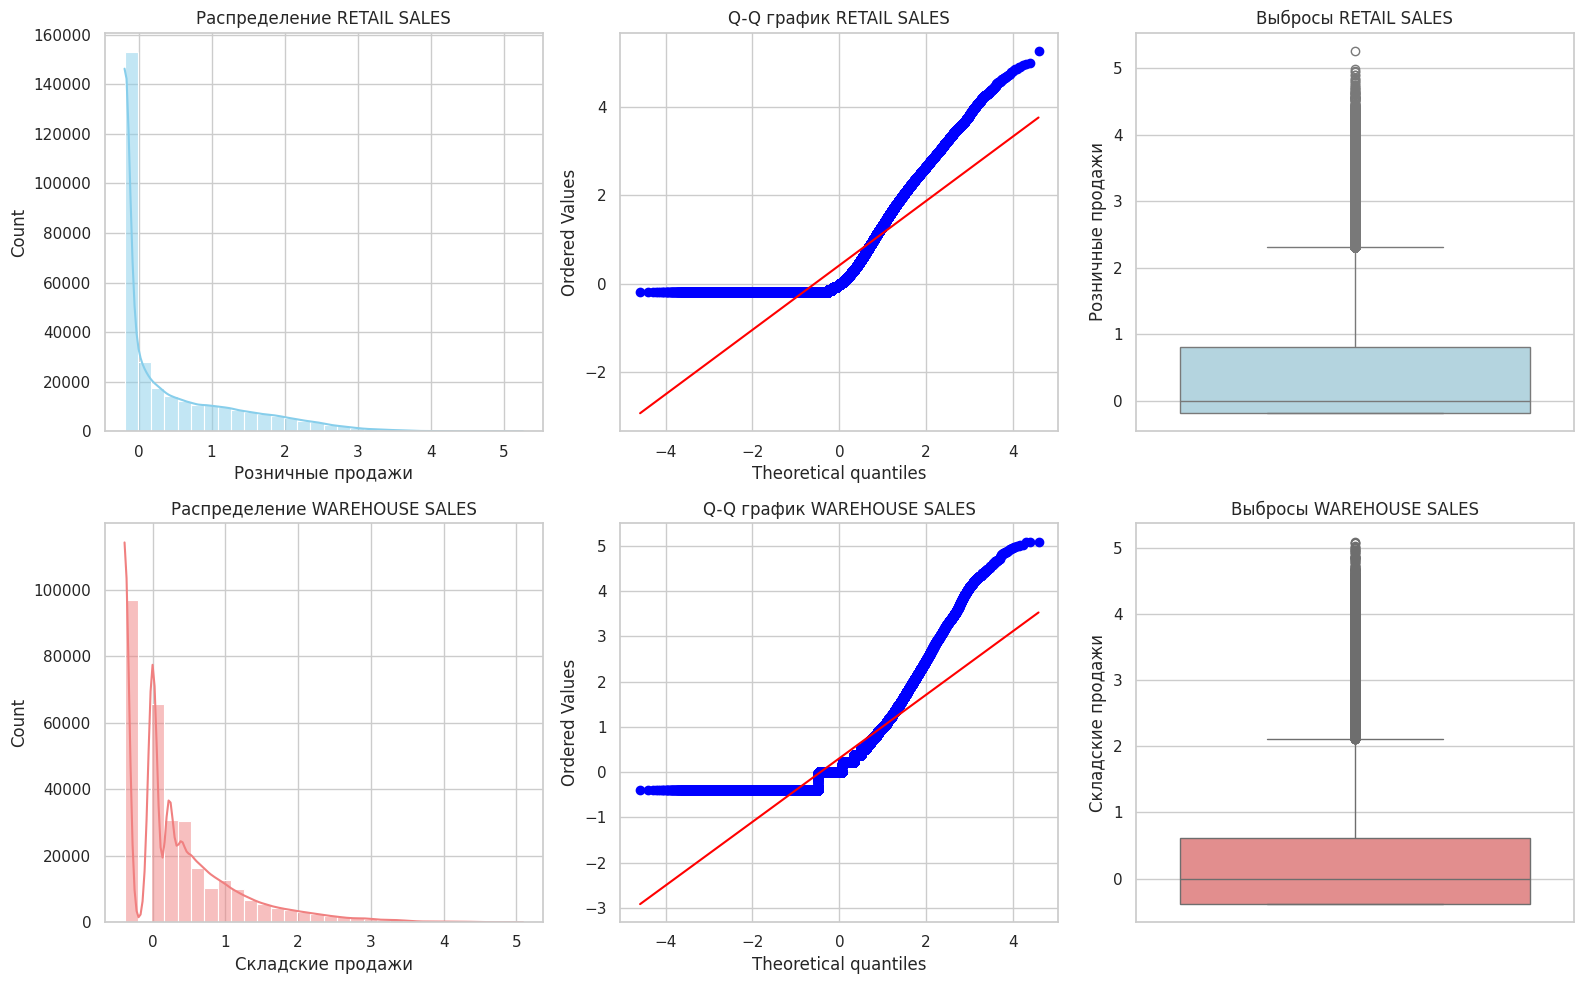

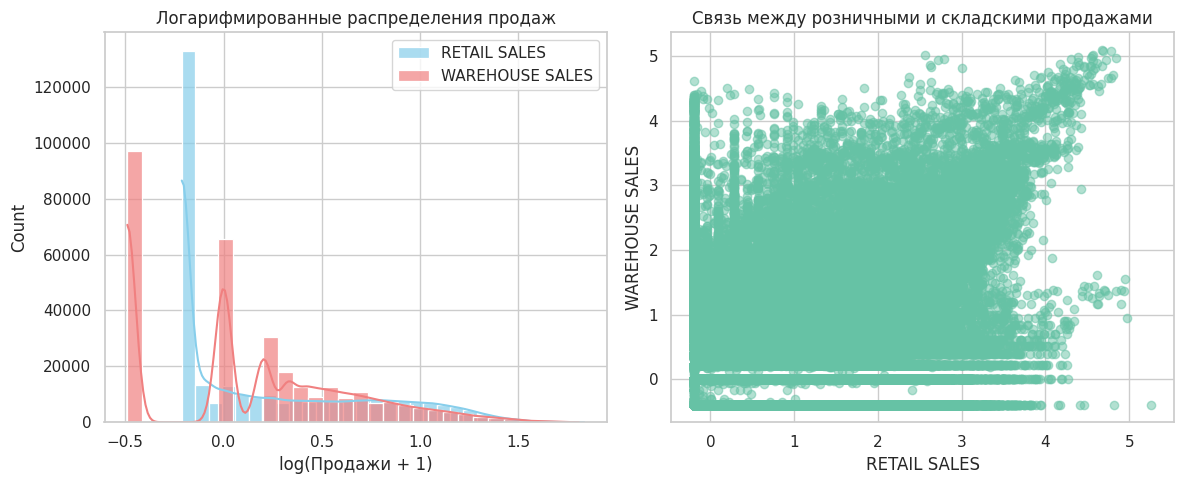

In [ ]:
plt.figure(figsize=(16, 10))

# Анализ RETAIL SALES
plt.subplot(2, 3, 1)
sns.histplot(df['RETAIL SALES'], bins=30, kde=True, color='skyblue')
plt.title('Распределение RETAIL SALES')
plt.xlabel('Розничные продажи')

plt.subplot(2, 3, 2)
stats.probplot(df['RETAIL SALES'], dist="norm", plot=plt)
plt.title('Q-Q график RETAIL SALES')

plt.subplot(2, 3, 3)
sns.boxplot(y=df['RETAIL SALES'], color='lightblue')
plt.title('Выбросы RETAIL SALES')
plt.ylabel('Розничные продажи')

# Анализ WAREHOUSE SALES
plt.subplot(2, 3, 4)
sns.histplot(df['WAREHOUSE SALES'], bins=30, kde=True, color='lightcoral')
plt.title('Распределение WAREHOUSE SALES')
plt.xlabel('Складские продажи')

plt.subplot(2, 3, 5)
stats.probplot(df['WAREHOUSE SALES'], dist="norm", plot=plt)
plt.title('Q-Q график WAREHOUSE SALES')

plt.subplot(2, 3, 6)
sns.boxplot(y=df['WAREHOUSE SALES'], color='lightcoral')
plt.title('Выбросы WAREHOUSE SALES')
plt.ylabel('Складские продажи')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# Логарифмированная версия для лучшей визуализации
retail_log = np.log1p(df['RETAIL SALES'])
warehouse_log = np.log1p(df['WAREHOUSE SALES'])

sns.histplot(retail_log, bins=30, kde=True, color='skyblue', alpha=0.7, label='RETAIL SALES')
sns.histplot(warehouse_log, bins=30, kde=True, color='lightcoral', alpha=0.7, label='WAREHOUSE SALES')
plt.title('Логарифмированные распределения продаж')
plt.xlabel('log(Продажи + 1)')
plt.legend()

plt.subplot(1, 2, 2)
# Scatter plot для визуализации связи между признаками
plt.scatter(df['RETAIL SALES'], df['WAREHOUSE SALES'], alpha=0.5)
plt.xlabel('RETAIL SALES')
plt.ylabel('WAREHOUSE SALES')
plt.title('Связь между розничными и складскими продажами')

plt.tight_layout()
plt.show()

# 6. Разбить данные на обучающую и тестовую выборки

Разделим наши данные на обучающую и тестовую выборки в соотношении 4 к 1. Мы делим выборку с учётом стратификации (`stratify=y`), чтобы в обучающей и тестовой частях сохранялись одинаковые пропорции по классам `ITEM TYPE`.
Это важно, так как классы могут быть несбалансированы.

In [ ]:
# Разделение данных на признаки и целевую переменную
df_sample = df.sample(frac=0.2, random_state=42)
X = df_sample.drop('ITEM TYPE', axis = 1)
y = df_sample['ITEM TYPE']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
X_train.shape, X_test.shape


((49223, 17), (12306, 17))

# 7. Запустить классификатор

**K ближайших соседей**

4 соседа

In [ ]:
model = KNeighborsClassifier(n_neighbors=4)
model.fit(X_train.values, y_train.values)
y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

# Оценка модели с использованием точности
train_accuracy = sklearn.metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)

print(f'Точность:\nОбучающая: {train_accuracy}, Тестовая: {test_accuracy}')
print("\nОтчет о классификации для тестовой выборки:")
print(sklearn.metrics.classification_report(y_test, y_test_pred))

Точность:
Обучающая: 0.8998638847693151, Тестовая: 0.8521046643913538

Отчет о классификации для тестовой выборки:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80      1699
           1       0.00      0.00      0.00         3
           2       0.62      0.35      0.45       396
           3       0.77      0.83      0.80      2581
           4       0.63      0.22      0.33        76
           5       0.00      0.00      0.00         6
           6       0.80      0.24      0.36        17
           7       0.92      0.89      0.91      7528

    accuracy                           0.85     12306
   macro avg       0.56      0.42      0.46     12306
weighted avg       0.85      0.85      0.85     12306



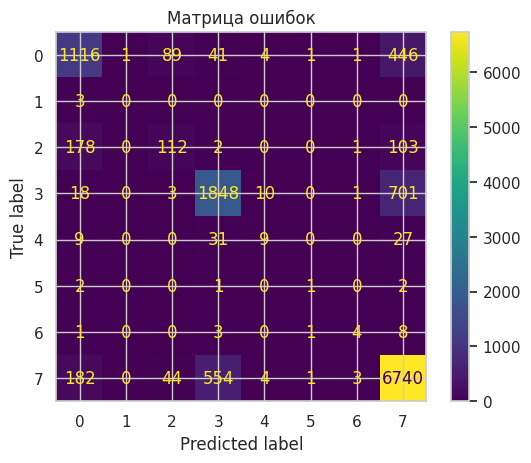

In [ ]:
# Создание матрицы ошибок
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

8 соседей

In [ ]:
model = KNeighborsClassifier(n_neighbors=8)
model.fit(X_train.values, y_train.values)
y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

# Оценка модели с использованием точности
train_accuracy = sklearn.metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = sklearn.metrics.accuracy_score(y_test, y_test_pred)

print(f'Точность:\nОбучающая: {train_accuracy}, Тестовая: {test_accuracy}')
print("\nОтчет о классификации для тестовой выборки:")
print(sklearn.metrics.classification_report(y_test, y_test_pred))

Точность:
Обучающая: 0.888710562135587, Тестовая: 0.856167723061921

Отчет о классификации для тестовой выборки:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80      1699
           1       0.00      0.00      0.00         3
           2       0.66      0.38      0.48       396
           3       0.79      0.81      0.80      2581
           4       0.81      0.28      0.41        76
           5       1.00      0.17      0.29         6
           6       1.00      0.35      0.52        17
           7       0.91      0.91      0.91      7528

    accuracy                           0.86     12306
   macro avg       0.74      0.47      0.53     12306
weighted avg       0.85      0.86      0.85     12306



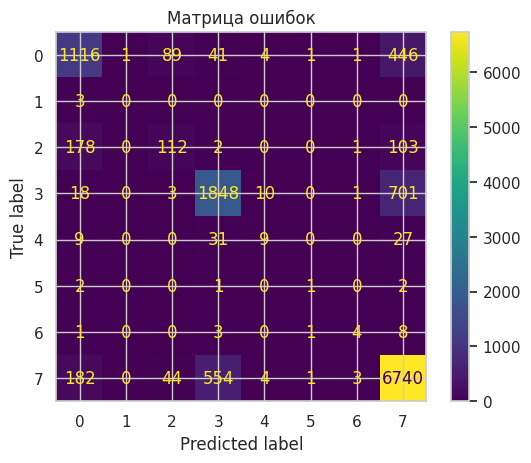

In [ ]:
# Создание матрицы ошибок
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

# 8. Вычислить ошибки на обучающей и тестовой выборках. Выбрать оптимальное значение гиперпараметра

Поиск оптимального количества соседей

In [ ]:
# Определение модели K ближайших соседей
model = KNeighborsClassifier()

# Подбор оптимального количества соседей с кросс-валидацией
grid = GridSearchCV(model, param_grid={'n_neighbors': range(2, 21)}, cv=10, scoring='accuracy')
grid.fit(X_train.values, y_train.values)

print(f"Оптимальное количество соседей: {grid.best_params_['n_neighbors']}")

# Получение модели с оптимальным числом соседей
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train.values)
y_test_pred = best_model.predict(X_test.values)

print(f"\nТочность:\nОбучающая: {accuracy_score(y_train, y_train_pred)}, Тестовая: {accuracy_score(y_test, y_test_pred)}")

Оптимальное количество соседей: 15

Точность:
Обучающая: 0.8802998598216281, Тестовая: 0.8602307817324882


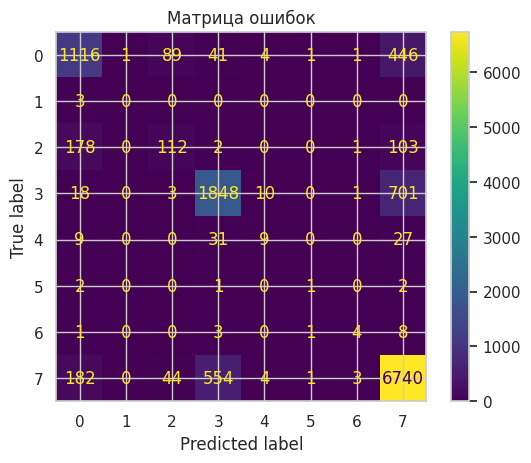

In [ ]:
# Создание матрицы ошибок
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

# 9. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы

Метод k ближайших соседей показал устойчивые результаты: при k=4 наблюдается переобучение — высокая точность на обучающей выборке (около 0.90) и меньшая на тестовой (0.85). При увеличении числа соседей до 8 и 15 разница между точностями уменьшается, что говорит о лучшей обобщающей способности модели. Оптимальным значением является k=15, где точность на тестовой выборке достигает около 0.86, а модель демонстрирует стабильное поведение без выраженного переобучения.

# 10. Запустить другие классификаторы и выбать параметры. Выбрать релевантные! Сравнить результаты

**Случайный лес**

In [ ]:
model = RandomForestClassifier(random_state=0)

# Обучение модели на тренировочной выборке
model.fit(X_train.values, y_train.values)

y_train_pred = model.predict(X_train.values)
y_test_pred = model.predict(X_test.values)

print(f"\nТочность:\nОбучающая: {accuracy_score(y_train, y_train_pred)}, Тестовая: {accuracy_score(y_test, y_test_pred)}")


Точность:
Обучающая: 0.9664181378623814, Тестовая: 0.7987973346335121


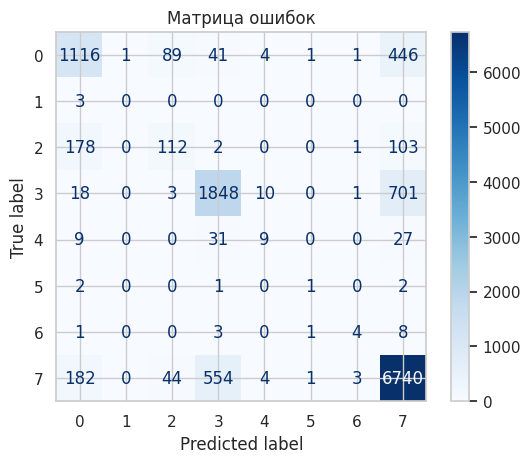

In [ ]:
# Создание матрицы ошибок
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

Поиск оптимальных гипер параметров

In [ ]:
model = RandomForestClassifier(random_state=42)

# Подбор оптимальных параметров с кросс-валидацией
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train.values, y_train.values)

print(f"Оптимальные параметры: {grid.best_params_}")
print(f"Лучшая точность при кросс-валидации: {grid.best_score_:.4f}")

# Получение модели с оптимальными параметрами
best_model = grid.best_estimator_

y_train_pred = best_model.predict(X_train.values)
y_test_pred = best_model.predict(X_test.values)

print(f"\nТочность:\nОбучающая: {accuracy_score(y_train, y_train_pred)}, Тестовая: {accuracy_score(y_test, y_test_pred)}")

# Анализ переобучения
overfitting_gap = accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)
print(f"Разница (переобучение): {overfitting_gap:.4f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Оптимальные параметры: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Лучшая точность при кросс-валидации: 0.8066

Точность:
Обучающая: 0.8962476890884342, Тестовая: 0.810580204778157
Разница (переобучение): 0.0857


In [ ]:
# Создание матрицы ошибок
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_test_pred)
confusion_matrix_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=model.classes_)
confusion_matrix_display.plot()
plt.title('Матрица ошибок')
plt.show()

AttributeError: 'RandomForestClassifier' object has no attribute 'classes_'

После подбора гиперпараметров для модели случайного леса качество модели заметно улучшилось. Точность на обучающей выборке составила примерно 0.90, а на тестовой — 0.81, при этом разница между ними снизилась до 0.086, что говорит о снижении переобучения и более стабильной работе модели.
В сравнении с методом ближайших соседей (точность 0.86 на тестовой выборке), случайный лес после настройки параметров показывает немного меньшую точность, но при этом обладает лучшей масштабируемостью и устойчивостью к шуму.

# 12. Сделать общие выводы

Мы начали с подготовки данных, включая стандартизацию и обработку выбросов. Это позволило улучшить обобщающую способность моделей и обеспечить их более стабильную работу на разнородных данных. После чего реализованы и сравнены модели k ближайших соседей и случайного леса. Метод KNN при оптимальном числе соседей k=15 показал точность 0.88 на обучающей и 0.86 на тестовой выборках, демонстрируя хорошее обобщение. Случайный лес после подбора параметров (n_estimators=100, min_samples_split=10, max_depth=None) дал точность 0.90 на обучающей и 0.81 на тестовой выборках, с разницей 0.0857, что указывает на небольшое переобучение. В целом, оба метода показали высокое качество классификации, однако KNN обеспечил более сбалансированные результаты, а Random Forest — лучшую интерпретируемость и устойчивость к шуму.

# 0. Подготовка данных

Здесь начинается подготовка данных для кластеризации. Сначала извлекаем целевые метки из столбца "outcome" и сохраняем их в переменную y. Эти метки представляют собой истинные значения для сравнения с результатами кластеризации. Признаки для кластеризации сохраняются в переменной X, из которой удаляется столбец с целевой переменной. Затем данные масштабируются с помощью стандартизации, приводя каждый признак к среднему значению 0 и стандартному отклонению 1.

In [ ]:
# Разделение данных на признаки и целевую переменную
df_sample = df.sample(frac=0.1, random_state=42)
X = df_sample.drop('ITEM TYPE', axis = 1)
y = df_sample['ITEM TYPE']

#scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Применение PCA

После подготовки данных их нужно проецировать в двумерное пространство для визуализации. Для этого используется метод главных компонент (PCA), который снижает размерность данных. Выбираем две компоненты для отображения данных в 2D. Это делается с помощью класса PCA из библиотеки sklearn.decomposition. Метод fit_transform применяет преобразование к данным, и мы получаем новые данные с двумя признаками для визуализации. PCA позволяет уменьшить количество признаков, сохраняя при этом максимум информации о различиях между объектами.

In [ ]:
pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_scaled)

# 2. Кластеризация

Здесь мы применяем три метода кластеризации для сравнения их эффективности в разделении объектов на группы.

KMeans:
Разделяет данные на фиксированное количество кластеров (в данном случае два).
Создаем объект KMeans, указываем количество кластеров как 2 и запускаем метод fit_predict, который обучает модель и предсказывает метки кластеров для каждого объекта.

DBSCAN:
Использует плотность данных для разделения объектов на кластеры.
Имеет параметры eps (максимальное расстояние между соседними точками в одном кластере) и min_samples (минимальное количество точек для плотной области).
Может помечать точки как выбросы (метка -1).

Иерархическая кластеризация (Agglomerative Clustering):
Строит дерево кластеров, начиная с каждого объекта как отдельного кластера и постепенно объединяя их в более крупные кластеры.
Выбираем два кластера и получаем метки кластеров для каждого объекта.

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)

In [ ]:
kmeans = MiniBatchKMeans(n_clusters=2, batch_size=1000, random_state=42)
kmeans_labels = kmeans.fit_predict(X_reduced)

In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(X_reduced)

In [ ]:
dbscan = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_reduced)

In [ ]:
agglo = AgglomerativeClustering(n_clusters=2)
agglo_labels = agglo.fit_predict(X_reduced)

# 3. Оценка качества кластеризации (ARI)

Для каждой из трех моделей (KMeans, DBSCAN, Agglomerative Clustering) мы вычисляем ARI с помощью функции adjusted_rand_score из библиотеки sklearn.metrics и выводим результаты. ARI для KMeans равен 0.1753, для DBSCAN — 0.1111, и для Agglomerative Clustering — 0.1028. Все значения достаточно низкие, что указывает на слабую корреляцию между кластеризацией и истинными метками. Наименьшее значение наблюдается для иерархической кластеризации, что свидетельствует о плохом разделении объектов.

In [ ]:
ari_kmeans = adjusted_rand_score(y, kmeans_labels)
ari_dbscan = adjusted_rand_score(y, dbscan_labels)
ari_agglo = adjusted_rand_score(y, agglo_labels)

# Выводим результаты ARI
print(f"ARI for KMeans: {ari_kmeans:.4f}")
print(f"ARI for DBSCAN: {ari_dbscan:.4f}")
print(f"ARI for Agglomerative Clustering: {ari_agglo:.4f}")

ARI for KMeans: 0.0634
ARI for DBSCAN: -0.0315
ARI for Agglomerative Clustering: 0.0460


# 4. Оценка качества кластеризации (Silhouette Score)

Здесь мы оцениваем качество кластеризации с помощью Silhouette Score, который измеряет, насколько хорошо каждый объект подходит к своему кластеру по сравнению с ближайшим соседним кластером. Значение варьируется от -1 до 1, где 1 означает хорошую кластеризацию, 0 — объект на границе двух кластеров, а -1 — ошибочное отнесение к кластеру.

In [ ]:
dbscan_labels_filtered = dbscan_labels[dbscan_labels != -1]
X_reduced_filtered = X_reduced[dbscan_labels != -1]

silhouette_kmeans = silhouette_score(X_reduced, kmeans_labels)
silhouette_dbscan = silhouette_score(X_reduced_filtered, dbscan_labels_filtered)
silhouette_agglo = silhouette_score(X_reduced, agglo_labels)

print(f"Silhouette Score for KMeans: {silhouette_kmeans:.4f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
print(f"Silhouette Score for Agglomerative Clustering: {silhouette_agglo:.4f}")

Silhouette Score for KMeans: 0.5695
Silhouette Score for DBSCAN: 0.5150
Silhouette Score for Agglomerative Clustering: 0.5222


# 5. Визуализация кластеров

В конце мы создаем графики, чтобы визуально оценить, как распределены объекты в каждом из кластеров для различных алгоритмов. Для этого используем метод scatterplot из библиотеки Seaborn, который строит диаграмму рассеяния. Мы отображаем данные, предварительно проецированные в двумерное пространство с помощью PCA, и для каждого алгоритма различным цветом выделяем объекты, принадлежащие разным кластерам. Это позволяет нам увидеть, как алгоритмы делят объекты, и в какой степени разделение соответствует друг другу.

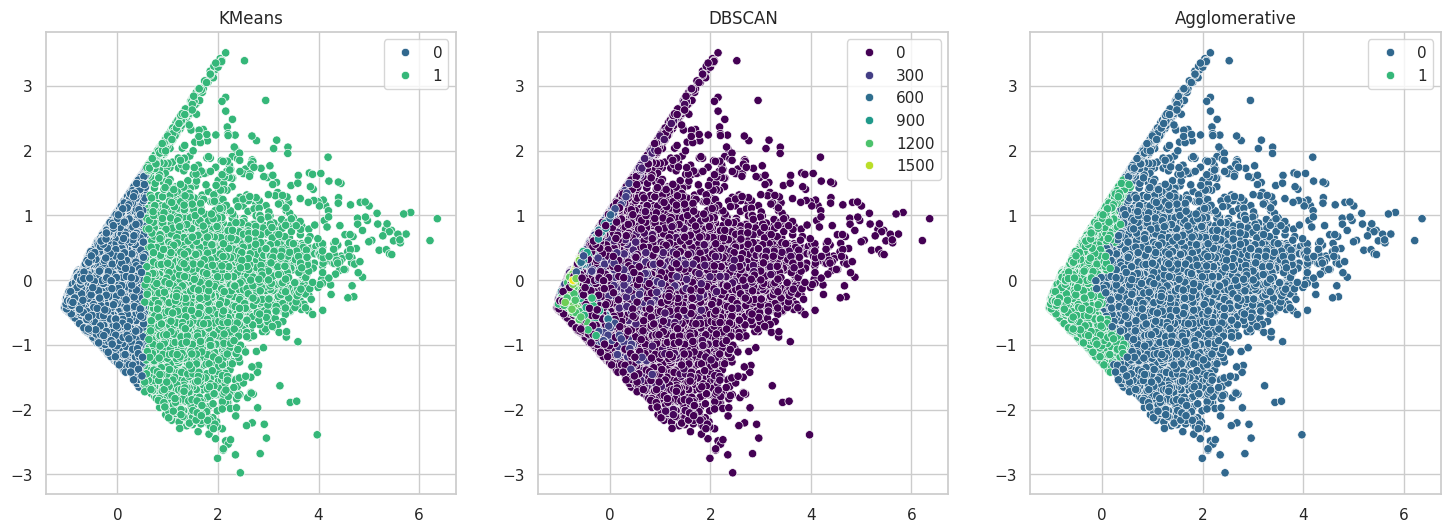

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=kmeans_labels, palette="viridis", ax=axs[0])
axs[0].set_title("KMeans")

sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=dbscan_labels, palette="viridis", ax=axs[1])
axs[1].set_title("DBSCAN")

sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=agglo_labels, palette="viridis", ax=axs[2])
axs[2].set_title("Agglomerative")

plt.show()

# 6. Вывод

На основе полученных результатов можно сделать вывод, что алгоритм KMeans показал наилучшие результаты кластеризации: он имеет самый высокий показатель Silhouette Score (0.5695), что свидетельствует о наиболее чётком разделении кластеров и их внутренней плотности. Значение ARI (0.0634) также является наибольшим среди трёх методов, что указывает на некоторое соответствие истинным меткам. Алгоритмы Agglomerative Clustering и DBSCAN показали более слабые результаты: их Silhouette Score составили 0.5222 и 0.5150 соответственно, а ARI оказался ниже (0.0460 и отрицательное значение −0.0315), что говорит о менее выраженных кластерах и возможных ошибках группировки. Таким образом, для данного набора данных метод KMeans оказался наиболее эффективным среди рассмотренных.